# Block 11: Multi Layer Perceptron

In [ ]:
import sklearn.metrics
import numpy as np
import jax
import jax.numpy as jnp
from typing import List
import pandas as pd
import numpy.random as rng
import matplotlib.pyplot as plt

## The Kinds of Functions that MLP Can Represent

(10000, 20)
(10000, 1)


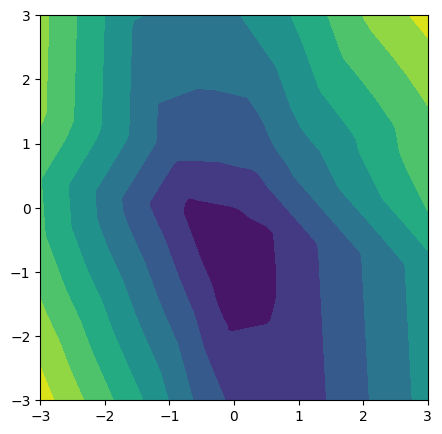

In [11]:
# Create a grid of points
K = 100
xs = np.linspace(-3, 3, K)
x1s, x2s = np.meshgrid(xs, xs)

# Number of data points x Number of input dimensions
X = np.vstack((x1s.flatten(), x2s.flatten())).T


# try varying the number of hidden units and see what happens
n_hidden = 20

# weight matrix from inputs to hidden neurons
W_input_hidden = rng.randn(2, n_hidden) # 2xH

# bias of the hidden neurons
b_hidden = rng.randn(n_hidden) # H

# weight matrix from hidden neurons to output
W_hidden_output = rng.randn(n_hidden, 1) # Hx1

# bias of the output neuron
b_output = rng.randn() # 1

# compute hidden activation
# We are using a RELU unit here
# Try removing the non-linearity and see what happens
u = np.maximum(0, b_hidden + X @ W_input_hidden ) # H + Nx2 @ 2xH = NxH
print(u.shape)

# compute output
y = b_output + u @ W_hidden_output # 1 + NxH @ Hx1 = Nx1
print(y.shape)

# plot
Z = np.reshape(y, (K, K))
f, ax = plt.subplots(1, 1, figsize=(5, 5))
cp = ax.contourf(x1s, x2s, Z)

# Implementing an MLP

In [77]:
def forward_fn(params, X):
    # NxM @ MxH = NxH
    h = jnp.maximum(0, X @ params['W_ih'])
    f = h @ params['W_ho'] + params['b_o'] # NxH @ Hx1 = Nx1
    
    return 1/(1+jnp.exp(-f))

def loss_fn(params, X, y):
    p = forward_fn(params, X)
    loss = -jnp.mean(y * jnp.log(p) + (1-y) * jnp.log(1-p))
    return loss 

class BinaryLinearModel():

    def __init__(self, 
                 features: List[str],
                 n_hidden: int):
        self._features = features 
        self.n_hidden = n_hidden

    def train(self, rng, 
              df: pd.DataFrame, 
              y: np.ndarray, 
              epochs: int = 100, 
              eta: float = 0.01, 
              batch_size: int = 100000):
        grad_fn = jax.grad(loss_fn)

        y = jnp.array(y)
        
        # prepare inputs and outputs
        X = self._prepare_input_matrix(df[self._features])
        
        #
        # randomly initialize solution 
        #
        rng2, rng3, rng4 = jax.random.split(rng, 3)
        params = dict(
            W_ih = jax.random.normal(rng, (X.shape[1], n_hidden)) * jnp.sqrt(2/X.shape[1]),
            W_ho = jax.random.normal(rng2, n_hidden) * jnp.sqrt(2/n_hidden),
            b_o = jax.random.normal(rng3)
        )

        # iterate for epochs
        history = []
        for i in range(epochs):

            # shuffle dataset (important)
            loop_key = jax.random.fold_in(rng4, i)
            ix = jax.random.permutation(loop_key, X.shape[0])
            X = X[ix, :]
            y = y[ix]

            # go over mini batches and update
            for j in range(0, X.shape[0], batch_size):
                offset = j 
                end = j + batch_size

                # compute gradient
                # this is very powerful ... JAX takes care of derivative computation
                # so loss_fn could be as complex as you like
                W_grad = grad_fn(params, X[offset:end,:], y[offset:end])
                
                # update solution
                params['W_ih'] = params['W_ih'] - eta * W_grad['W_ih']
                params['W_ho'] = params['W_ho'] - eta * W_grad['W_ho']
                params['b_o'] = params['b_o'] - eta * W_grad['b_o']
                
            # record epoch loss
            mse = loss_fn(params, X, y)
            print(mse)
            history.append([params, mse])

        # save the parameters
        self._params, _ = history[-1]

        return history
    
    def _prepare_input_matrix(self, df: pd.DataFrame):

        # we need to separate categorical from numeric features
        # because they require separate processing
        # let's get categorical columns
        categorical_cols = df.select_dtypes(include='object').columns
        
        # let's get numeric
        ordinal_cols = df.select_dtypes(include='number').columns

        # construct input features
        X = df[ordinal_cols].to_numpy()

        # z-score (NxK' - 1xK') / 1xK' = NxK'
        X = (X - np.mean(X, axis=0)[None, :]) / np.std(X, axis=0)[None, :]

        # code categorical features
        for feature in categorical_cols:
            dummies = pd.get_dummies(df[feature]).to_numpy().astype(float)
            X = np.hstack((X, dummies)) 

        # add a column of ones
        ones_col = np.ones((X.shape[0], 1)) # Nx1
        X = np.hstack((ones_col, X)) # K
        
        return jnp.array(X) 
    
    def predict(self, df: pd.DataFrame):
         
        X = self._prepare_input_matrix(df[self._features])

        return forward_fn(self._params, X)
    
df = pd.read_csv("../data/nonseparable_binary_data.csv")
df


rng = jax.random.key(52345)

#
# let's randomly split the data
#

# first, generate a shuffled permutation of indecies
ix = jax.random.permutation(rng, df.shape[0])
rng, _ = jax.random.split(rng)

# grab 80% of the shuffled data for training, rest is for testing
n_train = int(0.8 * df.shape[0])
train_ix = ix[:n_train]
test_ix = ix[n_train:]

train_df = df.iloc[train_ix]
test_df = df.iloc[test_ix]

model = BinaryLinearModel(['x1', 'x2'], n_hidden=20)

print("Train DF shape ", train_df.shape)
history = model.train(rng, train_df, train_df['y'].to_numpy(), epochs=100, eta=0.1, batch_size=10000)

# calculate null model on training data
mu = np.mean(train_df['y'].to_numpy())
# predict on test
print("Test DF shape ", test_df.shape)
yhat = model.predict(test_df)

# null model prediction
yhat_null = mu * np.ones(test_df.shape[0])

# hard decisions ...
threshold = 0.5 
yhat_hard = yhat > threshold
yhat_null_hard = yhat_null > threshold

ytrue = test_df['y'].to_numpy()

dict(
    accuracy = sklearn.metrics.accuracy_score(ytrue, yhat_hard),
    accuracy_null = sklearn.metrics.accuracy_score(ytrue, yhat_null_hard),
    
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(ytrue, yhat_hard),
    balanced_accuracy_null = sklearn.metrics.balanced_accuracy_score(ytrue, yhat_null_hard),

    recall = sklearn.metrics.recall_score(ytrue, yhat_hard),
    recall_null = sklearn.metrics.recall_score(ytrue, yhat_null_hard),

    precision = sklearn.metrics.precision_score(ytrue, yhat_hard),
    precision_null = sklearn.metrics.precision_score(ytrue, yhat_null_hard),

    f1 = sklearn.metrics.f1_score(ytrue, yhat_hard),
    f1_null = sklearn.metrics.f1_score(ytrue, yhat_null_hard),

    auc_roc = sklearn.metrics.roc_auc_score(ytrue, yhat),
    auc_pr = sklearn.metrics.average_precision_score(ytrue, yhat),
    auc_pr_null = sklearn.metrics.average_precision_score(ytrue, yhat_null),
)


Train DF shape  (800, 3)
1.1743915
1.0256258
0.9019973
0.8032685
0.72717
0.6698391
0.6268918
0.59440976
0.5693373
0.54947513
0.5333134
0.5198421
0.5083591
0.4983831
0.48957914
0.48171276
0.47460455
0.46812475
0.462166
0.45665526
0.4515303
0.44674137
0.4422402
0.4379951
0.43398347
0.43016827
0.4265331
0.42306075
0.41973543
0.41654998
0.41349223
0.41054812
0.40770838
0.40496063
0.40229544
0.39970893
0.39719543
0.39474872
0.39237297
0.39005858
0.38779938
0.38559517
0.38344023
0.38133293
0.37927005
0.37725127
0.37527576
0.37333807
0.37143654
0.3695704
0.3677401
0.36594412
0.3641788
0.3624453
0.36074367
0.35906744
0.3574145
0.3557869
0.3541846
0.352608
0.3510567
0.34952933
0.34802452
0.34654257
0.345083
0.34364635
0.3422329
0.34084052
0.3394683
0.33811572
0.33678043
0.335464
0.33416733
0.33288887
0.3316269
0.3303839
0.3291588
0.3279486
0.3267545
0.3255764
0.3244158
0.32327422
0.3221437
0.32102937
0.3199319
0.31884977
0.31778532
0.31673393
0.31569698
0.3146739
0.31366387
0.31266737
0.3116845

{'accuracy': 0.86,
 'accuracy_null': 0.455,
 'balanced_accuracy': 0.8670228853715092,
 'balanced_accuracy_null': 0.5,
 'recall': 0.945054945054945,
 'recall_null': 1.0,
 'precision': 0.7889908256880734,
 'precision_null': 0.455,
 'f1': 0.86,
 'f1_null': 0.6254295532646048,
 'auc_roc': 0.9645125516685149,
 'auc_pr': 0.9632585794190576,
 'auc_pr_null': 0.455}

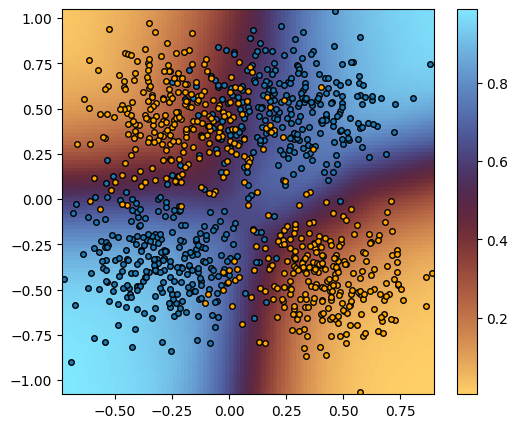

In [78]:
# initialize range of input values

min_x = np.min(df[['x1', 'x2']].to_numpy(), axis=0)
max_x = np.max(df[['x1', 'x2']].to_numpy(), axis=0)

K = 100
x1s = np.linspace(min_x[0], max_x[0], K)
x2s = np.linspace(min_x[1], max_x[1], K)
x1s, x2s = np.meshgrid(x1s, x2s)

# zip the inputs up into a (K*K, 2) array
Xstar = np.vstack((x1s.flatten(), x2s.flatten())).T

df_star = pd.DataFrame(data=Xstar, columns=['x1','x2'])

yhat = model.predict(df_star).reshape((K,K))

f, ax = plt.subplots(1, 1, figsize=(6, 5))

cp = ax.pcolor(x1s, x2s, yhat, cmap=plt.get_cmap('managua')) # 0: orange, 1: blue
f.colorbar(cp)

#
# plot the actual points
#
X = df[['x1','x2']].to_numpy()

y = df['y'].to_numpy()
class0_ix = y == 1 # y = 1, blue
class1_ix = y == 0 # y = 0, orange

ax.plot(X[class0_ix, 0], X[class0_ix, 1], marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)
ax.plot(X[class1_ix, 0], X[class1_ix, 1], color='orange', marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)
